# Histopathologic Cancer Detection Deep Model

<center>
    <h3>Utilizing deep learning to detect cancer in histopathologic images.</h3><br>
    <h5>By: Michael Hansen</h5>
    <h5>Date: 02/04/2025</h5>
    <h5>Course: DTSA5511 Deep Learning</h5>
    <h5>Instructor: Dr. Ying Sun</h5>
</center>


This notebook is an exploration into Deep Learning and it's use to detect cancer in histopathologic images. The dataset provided in this Kaggle competition is a collection of histopathologic images of breast cancer tumors. The goal is to build a model that can accurately detect cancer in these images.

The importance of being able to perform this task with a deep learning model cannot be understated as the benifits are too numerous to count. Thankfully there is a host of brilliant minds that have made a suite of tools that make this task easier. For this project I will be using the [Keras](https://keras.io/) library to build my model, and using ideas such as pooling, dropout, and batch normalization to improve the performance of my model.

The dataset can be found [here](https://www.kaggle.com/competitions/histopathologic-cancer-detection/data), and was originally obtained from the [TCGA](https://portal.gdc.cancer.gov/projects/TCGA-BRCA) project. The group at kaggle removed duplicates that originated from probablistic sampling. There are roughly 220,000 labeled images for training and about 57,000 for the test set.


In [3]:
# Importing Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting
from plotly.subplots import make_subplots # plotting
import plotly.graph_objs as go # plotting

from concurrent.futures import ThreadPoolExecutor
import multiprocessing
import cv2 # image processing
import gc # Clear Memory
from glob import glob # file handling
import os # file handling
from tqdm import tqdm

# deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation, Conv2D, MaxPool2D, Input, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau  # You might use these later
from tensorflow.keras.models import load_model

from sklearn.utils import shuffle
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split


In [4]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print("GPU Devices:", tf.config.list_physical_devices('GPU'))
#print("CUDA available:", torch.cuda.is_available())
#print("GPU Device Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU found")

TensorFlow version: 2.18.0
Num GPUs Available:  0
GPU Devices: []


In [5]:
file_path = 'G:/My Drive/Academia/C Data/'
train_path = file_path + "train/"
test_path = file_path + "test/"


labels = pd.read_csv(file_path + "train_labels.csv")
print("labels")
labels.head()



#final_data_frame = pd.concat([train_data_frame, test_data_frame]).reset_index(drop = True)

labels


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:

train_data_frame = pd.DataFrame({'path': [p.replace('\\', '/') for p in glob(os.path.join(train_path,'*.tif'))]})
train_data_frame['id'] = train_data_frame.path.map(lambda x: x.split('/')[5].split(".")[0])
df_data = train_data_frame.merge(labels, on = "id")
print("train")
df_data.head()

len(train_data_frame)

train


220025

In [7]:
test_data_frame = pd.DataFrame({'path': [p.replace('\\', '/') for p in glob(os.path.join(test_path,'*.tif'))]})

test_data_frame['id'] = test_data_frame.path.map(lambda x: x.split('/')[5].split(".")[0])
print("test")
print(len(test_data_frame))
test_data_frame.head()


test
57458


,path,id
0,G:/My Drive/Academia/C Data/test/00680dd398aaf...,00680dd398aaf3885ee39a5a3853e96c6d99ebcb
1,G:/My Drive/Academia/C Data/test/0060ae5d2ca3e...,0060ae5d2ca3e4c57d4736597a4c56e5942007b8
2,G:/My Drive/Academia/C Data/test/005f1d7c296b8...,005f1d7c296b81c8a775adde197ff540db73d042
3,G:/My Drive/Academia/C Data/test/005e7b500fa8b...,005e7b500fa8bd60a4abd0d352a199d57f570b10
4,G:/My Drive/Academia/C Data/test/0060269536500...,0060269536500f323a952b28ee090c106dc4e5a5


In [8]:
# Helper function to process and normalize images
def process_image(path):
    img = cv2.imread(path)
    return img

In [9]:
def load_data(N,data_frame):
    """ This functions loads N images using the data df
    """
    # Establish X as an array with 3 channels for each color value
    X = np.zeros([N,96,96,3],dtype=np.uint8) 
    # Convert the Labels object into an array
    y = np.squeeze(data_frame[['label']].to_numpy())[0:N]

    # set up multiprocessing
    num_workers = multiprocessing.cpu_count()-2
    # Create batches of paths to process
    paths = data_frame['path'].iloc[:N].tolist()
    # Use ThreadPoolExecutor for parallel image loading
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Process images in parallel
        results = list(executor.map(process_image, paths))
        
        # Store results in X array
        for i, img in enumerate(results):
            X[i] = img
            if i % 10 == 0:  # Reduced frequency of progress updates
                print(f"Processed {i}/{N} images")
    
    return X, y

In [10]:
# Load the pictures
N_pics=150
X,y = load_data(N=N_pics,data_frame=df_data)



Processed 0/150 images
Processed 10/150 images
Processed 20/150 images
Processed 30/150 images
Processed 40/150 images
Processed 50/150 images
Processed 60/150 images
Processed 70/150 images
Processed 80/150 images
Processed 90/150 images
Processed 100/150 images
Processed 110/150 images
Processed 120/150 images
Processed 130/150 images
Processed 140/150 images


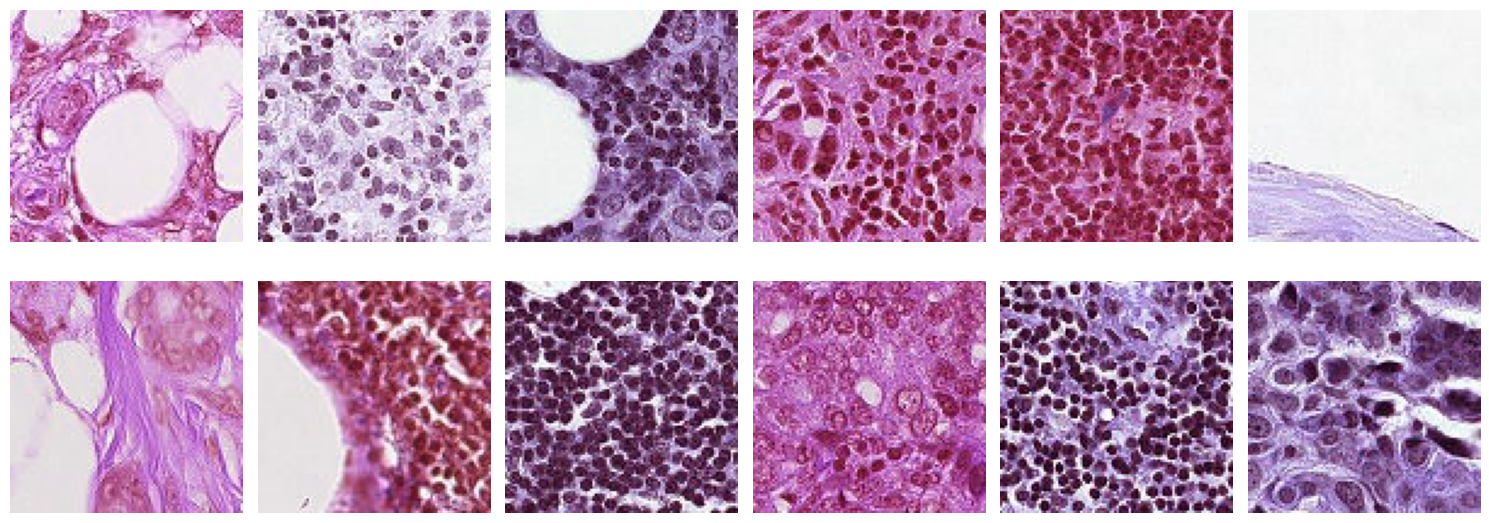


Label distribution in displayed samples:
Label 0: 6 images
Label 1: 6 images

Total dataset label distribution:
Label 0: 84 images (56.0%)
Label 1: 66 images (44.0%)


In [11]:
# Display a few sample images with their labels
plt.figure(figsize=(15,6))
num_samples = 12

# Randomly select indices to display
sample_indices = np.random.randint(0, len(X), num_samples)

for plotNr, idx in enumerate(sample_indices):
    ax = plt.subplot(2, num_samples//2, plotNr+1)
    plt.imshow(X[idx])
    plt.axis('off')

plt.tight_layout()
plt.show()

# Print distribution of labels in our sample
print(f"\nLabel distribution in displayed samples:")
unique, counts = np.unique(y[sample_indices], return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} images")

print(f"\nTotal dataset label distribution:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} images ({count/len(y)*100:.1f}%)")


Describe images

In [12]:
# Lay out the size and shape of the test and train

# Quick check for duplicates and NA

Describe the Data info & cleaning

Now we want to see if there is any distiguishable features we can look for visually ourselves. 
According to 
https://www.ncbi.nlm.nih.gov/books/NBK9553/#:~:text=Morphologically%2C%20the%20cancerous%20cell%20is,prominent%2C%20the%20cytoplasm%20is%20scarce
you can see differences in the size, shape, and potentially color of the cells in the images. This is good reason to dive into attributes of the pixels deeper. Each pixel has 3 channels, red, green, and blue. We can see that these are set on a scale from 0 to 255, 0 being the darkest of the color. 

And right there we have two characteristics. Brightness and Color. Both of these match characteristics listed in the article above so lets check it out. 

Comparing pairwise images would be impossible with data of this size and the resources / time at hand. What we can do is compare the amounts of each channel in each! The total sum gives the colors and the average will then give the brightness. 

In [13]:
#  Establish a new dataframe that puts an entry for each image, with the amount of R, G, and B in each image


In [14]:
# Graph

Text(0, 0.5, '# of samples')

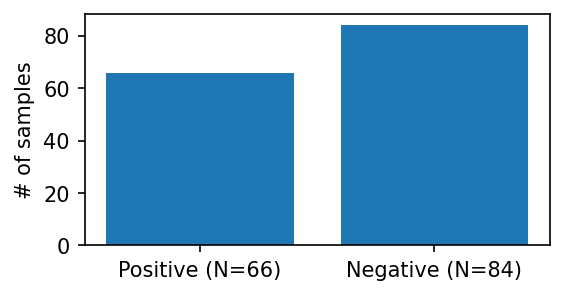

In [15]:
# Distribution statistic
fig = plt.figure(figsize=(4, 2),dpi=150)
plt.bar([1,0], [(y==0).sum(), (y==1).sum()]); #plot a bar chart of the label frequency
plt.xticks([1,0],["Negative (N={})".format((y==0).sum()),"Positive (N={})".format((y==1).sum())]);
plt.ylabel("# of samples")

Describe

In [16]:
# split data
positive_samples = X[y == 1]
negative_samples = X[y == 0]

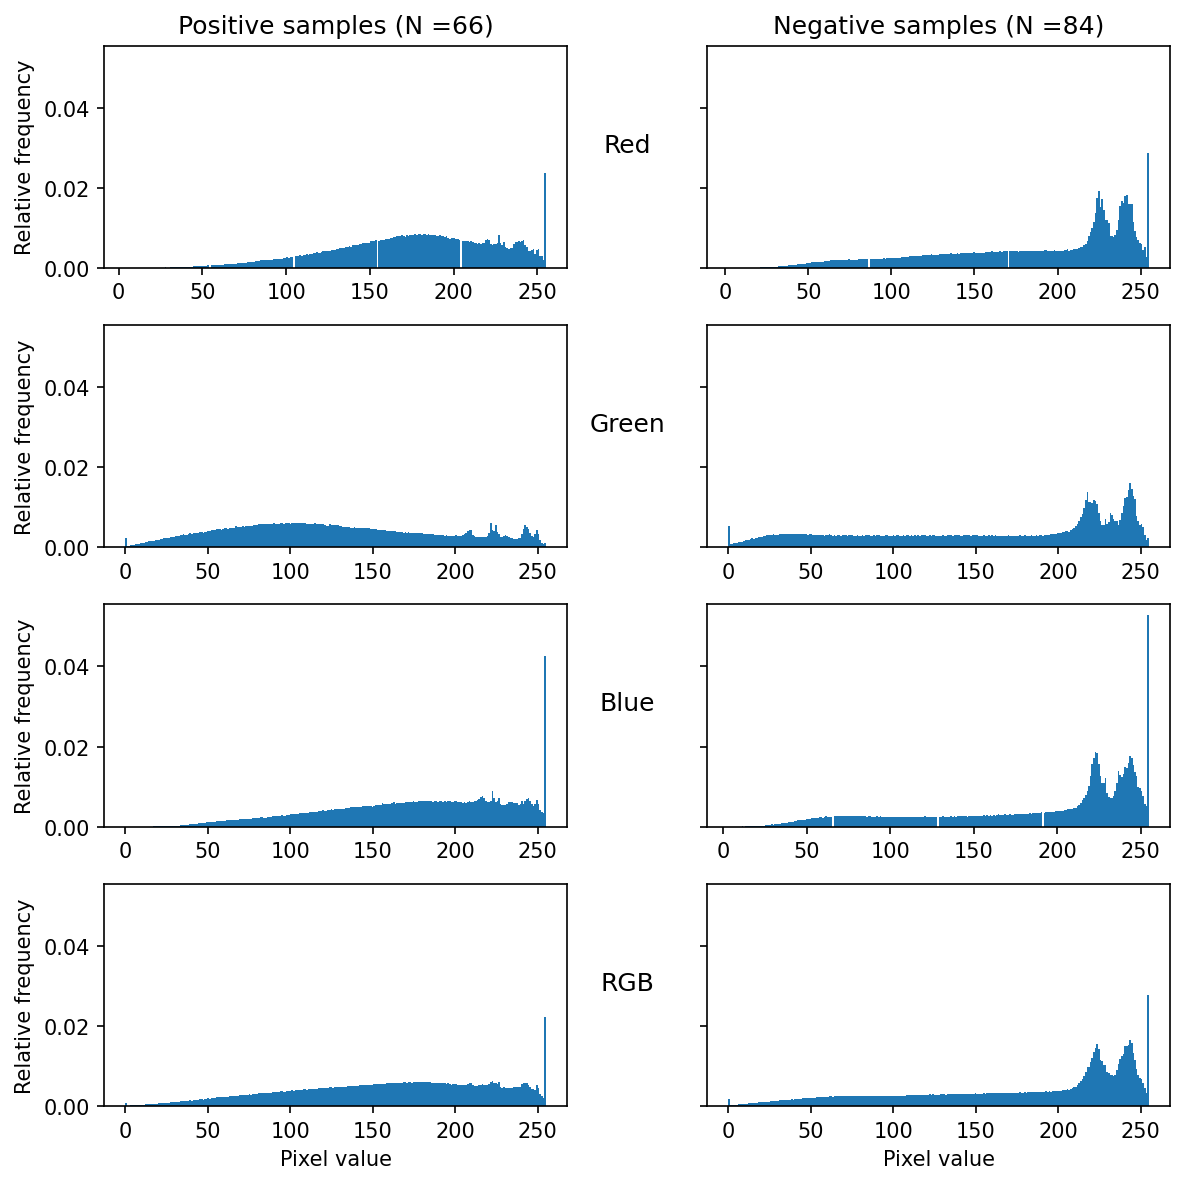

In [17]:
nr_of_bins = 256 #each possible pixel value will get a bin in the following histograms
fig,axs = plt.subplots(4,2,sharey=True,figsize=(8,8),dpi=150)

#RGB channels
axs[0,0].hist(positive_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[0,1].hist(negative_samples[:,:,:,0].flatten(),bins=nr_of_bins,density=True)
axs[1,0].hist(positive_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[1,1].hist(negative_samples[:,:,:,1].flatten(),bins=nr_of_bins,density=True)
axs[2,0].hist(positive_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)
axs[2,1].hist(negative_samples[:,:,:,2].flatten(),bins=nr_of_bins,density=True)

#All channels
axs[3,0].hist(positive_samples.flatten(),bins=nr_of_bins,density=True)
axs[3,1].hist(negative_samples.flatten(),bins=nr_of_bins,density=True)

#Set image labels
axs[0,0].set_title("Positive samples (N =" + str(positive_samples.shape[0]) + ")");
axs[0,1].set_title("Negative samples (N =" + str(negative_samples.shape[0]) + ")");
axs[0,1].set_ylabel("Red",rotation='horizontal',labelpad=35,fontsize=12)
axs[1,1].set_ylabel("Green",rotation='horizontal',labelpad=35,fontsize=12)
axs[2,1].set_ylabel("Blue",rotation='horizontal',labelpad=35,fontsize=12)
axs[3,1].set_ylabel("RGB",rotation='horizontal',labelpad=35,fontsize=12)
for i in range(4):
    axs[i,0].set_ylabel("Relative frequency")
axs[3,0].set_xlabel("Pixel value")
axs[3,1].set_xlabel("Pixel value")
fig.tight_layout()

In [18]:
N = df_data["path"].size # get the number of images in the training data set
print(N)

220025


In [19]:
# Changed to 1000 for testing
X,y = load_data(N=N,data_frame=df_data)

Processed 0/220025 images
Processed 10/220025 images
Processed 20/220025 images
Processed 30/220025 images
Processed 40/220025 images
Processed 50/220025 images
Processed 60/220025 images
Processed 70/220025 images
Processed 80/220025 images
Processed 90/220025 images
Processed 100/220025 images
Processed 110/220025 images
Processed 120/220025 images
Processed 130/220025 images
Processed 140/220025 images
Processed 150/220025 images
Processed 160/220025 images
Processed 170/220025 images
Processed 180/220025 images
Processed 190/220025 images
Processed 200/220025 images
Processed 210/220025 images
Processed 220/220025 images
Processed 230/220025 images
Processed 240/220025 images
Processed 250/220025 images
Processed 260/220025 images
Processed 270/220025 images
Processed 280/220025 images
Processed 290/220025 images
Processed 300/220025 images
Processed 310/220025 images
Processed 320/220025 images
Processed 330/220025 images
Processed 340/220025 images
Processed 350/220025 images
Pro

In [24]:
positives_samples = None
negative_samples = None
gc.collect();

In [25]:
training_portion = 0.8 # Specify training/validation ratio
split_idx = int(np.round(training_portion * y.shape[0])) #Compute split idx

# set the seed to ensure reproducibility
np.random.seed(42) 

# randomly shake up our X and Y 
idx = np.arange(y.shape[0])
np.random.shuffle(idx)
X = X[idx]
y = y[idx]
#_train, X_val, y_train, y_val = train_test_split(X, y, train_size=TRAINING_PORTION, random_state=42, stratify=y) #Stratified splitting!


In [26]:
#just some network parameters, see above link regarding the layers for details
kernel_size = (3,3)
pool_size= (2,2)
first_filters = 32
second_filters = 64
third_filters = 128

#dropout is used for regularization here with a probability of 0.3 for conv layers, 0.5 for the dense layer at the end
dropout_conv = 0.3
dropout_dense = 0.5


# Create model with Input layer
inputs = Input(shape=(96, 96, 3))

# Conv block 1
x = Conv2D(first_filters, kernel_size)(inputs)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(first_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

# Conv block 2
x = Conv2D(second_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(second_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

# Conv block 3
x = Conv2D(third_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Conv2D(third_filters, kernel_size, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = MaxPool2D(pool_size=pool_size)(x)
x = Dropout(dropout_conv)(x)

# Fully connected layer
x = Flatten()(x)
x = Dense(256, use_bias=False)(x)
x = BatchNormalization()(x)
x = Activation("relu")(x)
x = Dropout(dropout_dense)(x)

# Output layer
outputs = Dense(1, activation="sigmoid")(x)

In [27]:
model = Model(inputs=inputs, outputs=outputs)

# model = load_model('cancer_detection_model')

In [28]:
batch_size = 500

model.compile(loss=tf.keras.losses.binary_crossentropy,
              optimizer=tf.keras.optimizers.Adam(0.001), 
              metrics=['accuracy'])

In [29]:
# training
epochs = 3 #how many epochs we want to perform
for epoch in range(epochs):
    #compute how many batches we'll need
    iterations = np.floor(split_idx / batch_size).astype(int) #the floor makes us discard a few samples here, I got lazy...
    loss,acc = 0,0 #we will compute running loss and accuracy
    for i in range(iterations):
        start_idx = i * batch_size #starting index of the current batch
        x_batch = X[start_idx:start_idx+batch_size] #the current batch
        y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch

        metrics = model.train_on_batch(x_batch, y_batch) #train the model on a batch

        loss = loss + metrics[0] #compute running loss
        acc = acc + metrics[1] #compute running accuracy
        print(f'Running training epoch {epoch} - batch {i+1}/{iterations}, loss: {loss/(i+1):.2f}, acc: {acc/(i+1):.2f}', end='\r')

In [31]:
# Save the entire model (architecture + weights + optimizer state)
model.save('cancer_detection_model.keras')

# model = load_model('cancer_detection_model')

# Explain training

In [32]:
#Validation
#compute how many batches we'll need
iterations = np.floor((y.shape[0]-split_idx) / batch_size).astype(int) #as above, not perfect
loss,acc = 0,0 #we will compute running loss and accuracy
for i in range(iterations):
    start_idx = i * batch_size #starting index of the current batch
    x_batch = X[start_idx:start_idx+batch_size] #the current batch
    y_batch = y[start_idx:start_idx+batch_size] #the labels for the current batch
    
    metrics = model.test_on_batch(x_batch, y_batch) #compute metric results for this batch using the model
    
    loss = loss + metrics[0] #compute running loss
    acc = acc + metrics[1] #compute running accuracy
    print(f'Running validation - batch {i+1}/{iterations}, loss: {loss/(i+1):.2f}, acc: {acc/(i+1):.2f}', end='\r')
    
print("\nValidation loss:",loss / iterations)
print("Validation accuracy:",acc / iterations)

Running validation - batch 88/88, loss: 0.32, acc: 0.87
Validation loss: 0.31858962232416327
Validation accuracy: 0.8679420297796075


# Explain Validation

In [33]:
X = None
y = None
gc.collect();

In [35]:
# Submission
submission = pd.DataFrame() #create a dataframe to hold results
max_idx = len(test_data_frame) #get total number of test samples
file_batch = 500
target_size = (96, 96)  # The size your model expects

#

for idx in tqdm(range(0, max_idx, file_batch), desc="Processing test batches", unit="batch"):
    batch_df = test_data_frame.iloc[idx:idx+file_batch].copy()
    
    # Load and preprocess images
    batch_images = []
    valid_indices = []
    paths = batch_df['path'].tolist()
    # Set up multiprocessing
    num_workers = multiprocessing.cpu_count()-2
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        # Process images in parallel
        results = list(executor.map(process_image, paths))
        
        # Filter valid results
        for i, img in enumerate(results):
            if img is not None and img.shape == (*target_size, 3):
                batch_images.append(img)
                valid_indices.append(i)
            else:
                print(f"Skipping image {paths[i]} due to invalid shape: {img.shape if img is not None else 'None'}")
    
    if not batch_images:
        print(f"No valid images in batch starting at index {idx}")
        continue
        
    K_test = np.stack(batch_images)  # Using stack instead of array
    predictions = model.predict(K_test, verbose=1)
    
    # Ensure predictions are properly formatted
    predictions = predictions.flatten()
    
    # Only use valid indices
    batch_df = batch_df.iloc[valid_indices]
    batch_df['label'] = predictions
    
    # Add batch results to submission dataframe
    submission = pd.concat([submission, batch_df[["id", "label"]]])
    submission.to_csv("submission.csv", index = False, header = True) #create the submission file

Processing test batches:   0%|          | 0/115 [00:00<?, ?batch/s]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   1%|          | 1/115 [00:01<02:44,  1.44s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:   2%|▏         | 2/115 [00:02<02:36,  1.38s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   3%|▎         | 3/115 [00:20<16:10,  8.67s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   3%|▎         | 4/115 [00:37<22:35, 12.21s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   4%|▍         | 5/115 [00:55<25:45, 14.05s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   5%|▌         | 6/115 [01:12<27:32, 15.16s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   6%|▌         | 7/115 [01:29<28:32, 15.86s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:   7%|▋         | 8/115 [01:46<29:03, 16.29s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   8%|▊         | 9/115 [02:04<29:17, 16.58s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:   9%|▊         | 10/115 [02:21<29:21, 16.78s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  10%|▉         | 11/115 [02:38<29:17, 16.90s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  10%|█         | 12/115 [02:55<29:11, 17.00s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  11%|█▏        | 13/115 [03:13<29:02, 17.08s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  12%|█▏        | 14/115 [03:30<28:49, 17.13s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  13%|█▎        | 15/115 [03:47<28:36, 17.16s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  14%|█▍        | 16/115 [04:04<28:21, 17.19s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  15%|█▍        | 17/115 [04:21<28:05, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  16%|█▌        | 18/115 [04:39<27:48, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  17%|█▋        | 19/115 [04:56<27:32, 17.22s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  17%|█▋        | 20/115 [05:13<27:13, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  18%|█▊        | 21/115 [05:30<26:59, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  19%|█▉        | 22/115 [05:48<26:45, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  20%|██        | 23/115 [06:05<26:27, 17.25s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  21%|██        | 24/115 [06:22<26:11, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  22%|██▏       | 25/115 [06:40<25:55, 17.29s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  23%|██▎       | 26/115 [06:57<25:36, 17.26s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  23%|██▎       | 27/115 [07:14<25:11, 17.18s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  24%|██▍       | 28/115 [07:31<24:54, 17.17s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  25%|██▌       | 29/115 [07:48<24:21, 16.99s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  26%|██▌       | 30/115 [08:05<24:08, 17.04s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  27%|██▋       | 31/115 [08:22<23:59, 17.13s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  28%|██▊       | 32/115 [08:39<23:47, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  29%|██▊       | 33/115 [08:57<23:30, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  30%|██▉       | 34/115 [09:14<23:15, 17.22s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  30%|███       | 35/115 [09:31<22:57, 17.22s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  31%|███▏      | 36/115 [09:48<22:39, 17.21s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  32%|███▏      | 37/115 [10:05<22:18, 17.16s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  33%|███▎      | 38/115 [10:22<21:58, 17.13s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  34%|███▍      | 39/115 [10:39<21:31, 17.00s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  35%|███▍      | 40/115 [10:56<21:21, 17.09s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  36%|███▌      | 41/115 [11:14<21:08, 17.14s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  37%|███▋      | 42/115 [11:31<20:53, 17.17s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  37%|███▋      | 43/115 [11:48<20:39, 17.21s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  38%|███▊      | 44/115 [12:06<20:25, 17.26s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  39%|███▉      | 45/115 [12:23<20:04, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  40%|████      | 46/115 [12:40<19:47, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  41%|████      | 47/115 [12:57<19:34, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  42%|████▏     | 48/115 [13:15<19:19, 17.31s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  43%|████▎     | 49/115 [13:32<19:00, 17.28s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  43%|████▎     | 50/115 [13:49<18:40, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  44%|████▍     | 51/115 [14:06<18:22, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  45%|████▌     | 52/115 [14:23<18:02, 17.19s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  46%|████▌     | 53/115 [14:40<17:42, 17.14s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  47%|████▋     | 54/115 [14:57<17:18, 17.02s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  48%|████▊     | 55/115 [15:14<17:03, 17.05s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  49%|████▊     | 56/115 [15:31<16:46, 17.06s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  50%|████▉     | 57/115 [15:48<16:24, 16.97s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  50%|█████     | 58/115 [16:05<16:12, 17.06s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  51%|█████▏    | 59/115 [16:23<16:03, 17.21s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  52%|█████▏    | 60/115 [16:40<15:49, 17.26s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  53%|█████▎    | 61/115 [16:58<15:34, 17.30s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  54%|█████▍    | 62/115 [17:15<15:15, 17.28s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  55%|█████▍    | 63/115 [17:32<14:56, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  56%|█████▌    | 64/115 [17:49<14:39, 17.24s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  57%|█████▋    | 65/115 [18:06<14:09, 16.98s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  57%|█████▋    | 66/115 [18:23<13:56, 17.08s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


Processing test batches:  58%|█████▊    | 67/115 [18:40<13:43, 17.16s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  59%|█████▉    | 68/115 [18:58<13:29, 17.22s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  60%|██████    | 69/115 [19:15<13:14, 17.28s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  61%|██████    | 70/115 [19:32<12:54, 17.22s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  62%|██████▏   | 71/115 [19:50<12:40, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  63%|██████▎   | 72/115 [20:07<12:21, 17.24s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  63%|██████▎   | 73/115 [20:24<12:07, 17.32s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  64%|██████▍   | 74/115 [20:41<11:46, 17.24s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  65%|██████▌   | 75/115 [20:59<11:31, 17.28s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  66%|██████▌   | 76/115 [21:16<11:13, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  67%|██████▋   | 77/115 [21:33<10:56, 17.28s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  68%|██████▊   | 78/115 [21:50<10:39, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  69%|██████▊   | 79/115 [22:08<10:21, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  70%|██████▉   | 80/115 [22:25<10:05, 17.30s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  70%|███████   | 81/115 [22:42<09:48, 17.30s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing test batches:  71%|███████▏  | 82/115 [23:00<09:30, 17.30s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  72%|███████▏  | 83/115 [23:17<09:11, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  73%|███████▎  | 84/115 [23:34<08:54, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  74%|███████▍  | 85/115 [23:51<08:38, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  75%|███████▍  | 86/115 [24:09<08:21, 17.28s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  76%|███████▌  | 87/115 [24:26<08:04, 17.30s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  77%|███████▋  | 88/115 [24:43<07:46, 17.28s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  77%|███████▋  | 89/115 [25:00<07:28, 17.26s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  78%|███████▊  | 90/115 [25:17<07:10, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  79%|███████▉  | 91/115 [25:35<06:53, 17.24s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  80%|████████  | 92/115 [25:52<06:37, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  81%|████████  | 93/115 [26:09<06:19, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  82%|████████▏ | 94/115 [26:27<06:02, 17.26s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  83%|████████▎ | 95/115 [26:44<05:45, 17.27s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  83%|████████▎ | 96/115 [27:01<05:26, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  84%|████████▍ | 97/115 [27:18<05:09, 17.19s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  85%|████████▌ | 98/115 [27:35<04:50, 17.07s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  86%|████████▌ | 99/115 [27:52<04:33, 17.10s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  87%|████████▋ | 100/115 [28:09<04:16, 17.10s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  88%|████████▊ | 101/115 [28:26<03:59, 17.13s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  89%|████████▊ | 102/115 [28:44<03:43, 17.17s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  90%|████████▉ | 103/115 [29:01<03:26, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  90%|█████████ | 104/115 [29:18<03:09, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  91%|█████████▏| 105/115 [29:35<02:52, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  92%|█████████▏| 106/115 [29:53<02:35, 17.26s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  93%|█████████▎| 107/115 [30:10<02:17, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  94%|█████████▍| 108/115 [30:27<02:00, 17.18s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  95%|█████████▍| 109/115 [30:44<01:42, 17.01s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  96%|█████████▌| 110/115 [31:01<01:25, 17.07s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  97%|█████████▋| 111/115 [31:18<01:08, 17.15s/batch]

Skipping image G:/My Drive/Academia/C Data/test/f8fa1ea6cba65d2e733a3c280b47624a77206fae.tif due to invalid shape: None
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  97%|█████████▋| 112/115 [31:35<00:51, 17.20s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches:  98%|█████████▊| 113/115 [31:53<00:34, 17.23s/batch]

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


Processing test batches:  99%|█████████▉| 114/115 [32:10<00:17, 17.23s/batch]

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


Processing test batches: 100%|██████████| 115/115 [32:26<00:00, 16.93s/batch]


In [99]:
submission.to_csv("submission.csv", index = False, header = True) #create the submission file